# Flight On Time #
## Proceso EDA ##

In [ ]:
import pandas as pd

df = pd.read_csv("flight_data.csv")
# fuente:https://drive.google.com/file/d/0B15CJLF8tnDhV0x4WW9MblF4Y2c/view?resourcekey=0-kxbbW7oedPrCZh9uffB_tQ
print(df.shape)
print(df.dtypes)
df.head()

(336776, 19)
year                int64
month               int64
day                 int64
dep_time          float64
sched_dep_time      int64
dep_delay         float64
arr_time          float64
sched_arr_time      int64
arr_delay         float64
carrier            object
flight              int64
tailnum            object
origin             object
dest               object
air_time          float64
distance            int64
hour                int64
minute              int64
time_hour          object
dtype: object


,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,01-01-2013 05:00
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,01-01-2013 05:00
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,01-01-2013 05:00
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,01-01-2013 05:00
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,01-01-2013 06:00


## Diccionario de variables ##

| Variable original   | Traducción                     | Descripción                                                                 |
|:-------------------:|:------------------------------:|-----------------------------------------------------------------------------|
| year                | Año                            | Año en que se realizó el vuelo                                              |
| month               | Mes                            | Mes del vuelo (1–12)                                                        |
| day                 | Día                            | Día del mes en que se realizó el vuelo                                      |
| dep_time            | Hora de salida real            | Hora en que el vuelo despegó realmente                                      |
| sched_dep_time      | Hora de salida programada      | Hora programada para el despegue                                            |
| dep_delay           | Demora en salida (minutos)     | Diferencia en minutos entre salida real y programada                        |
| arr_time            | Hora de llegada real           | Hora en que el vuelo aterrizó realmente                                     |
| sched_arr_time      | Hora de llegada programada     | Hora programada para el aterrizaje                                          |
| arr_delay           | Demora en llegada (minutos)    | Diferencia en minutos entre llegada real y programada                       |
| carrier             | Aerolínea (código)             | Código de la aerolínea que operó el vuelo                                   |
| flight              | Número de vuelo                | Identificador numérico del vuelo                                            |
| tailnum             | Matrícula del avión            | Número de registro de la aeronave                                           |
| origin              | Aeropuerto de origen           | Código IATA del aeropuerto de salida                                        |
| dest                | Aeropuerto de destino          | Código IATA del aeropuerto de llegada                                       |
| air_time            | Tiempo en aire (minutos)       | Duración del vuelo en minutos                                               |
| distance            | Distancia (millas)             | Distancia entre origen y destino en millas                                  |
| hour                | Hora (extraída)                | Hora del día asociada al vuelo                                              |
| minute              | Minuto (extraído)              | Minuto del día asociado al vuelo                                            |
| time_hour           | Fecha-hora redondeada          | Marca temporal agrupada por hora                                            |

In [ ]:
# Conversión de tipos
# Reconstruir fecha 
df["date"] = pd.to_datetime(df[["year","month","day"]])

# Categóricos
for col in ["carrier","origin","dest","tailnum"]:
    df[col] = df[col].astype("category")

# Numéricos
for col in ["dep_delay","arr_delay","air_time","distance"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")


Calidad de los datos:
“Antes de analizar: ¿qué tan confiable es este registro de vuelos? Revisamos si hay vacios de información, duplicados o valores imposibles. Encontramos que las demoras pueden ser negativas (sí algunos vuelos llegaron antes de lo previsto) y que hay registros repetidos que debemos limpiar.”

In [23]:
# 3 Calidad de datos
# Nulos
print(df.isna().sum())

year                 0
month                0
day                  0
dep_time          8255
sched_dep_time       0
dep_delay         8255
arr_time          8713
sched_arr_time       0
arr_delay         9430
carrier              0
flight               0
tailnum           2512
origin               0
dest                 0
air_time          9430
distance             0
hour                 0
minute               0
time_hour            0
date                 0
dtype: int64


In [24]:
# Duplicados
print("Duplicados:", df.duplicated().sum())

Duplicados: 0


In [25]:
# Valores imposibles
print(df[["dep_delay","arr_delay","air_time","distance"]].describe())

           dep_delay      arr_delay       air_time       distance
count  328521.000000  327346.000000  327346.000000  336776.000000
mean       12.639070       6.895377     150.686460    1039.912604
std        40.210061      44.633292      93.688305     733.233033
min       -43.000000     -86.000000      20.000000      17.000000
25%        -5.000000     -17.000000      82.000000     502.000000
50%        -2.000000      -5.000000     129.000000     872.000000
75%        11.000000      14.000000     192.000000    1389.000000
max      1301.000000    1272.000000     695.000000    4983.000000


3. Las demoras: el corazón del análisis
“Cuando miramos la distribución de las demoras, aparece la historia principal: la mayoría de los vuelos se mueve entre adelantos pequeños y retrasos moderados, pero hay una cola larga de vuelos que se atrasan mucho. La mediana está cerca de 10 minutos, lo que nos dice que la experiencia típica es un retraso leve, aunque algunos pasajeros sufren esperas mucho más largas.”

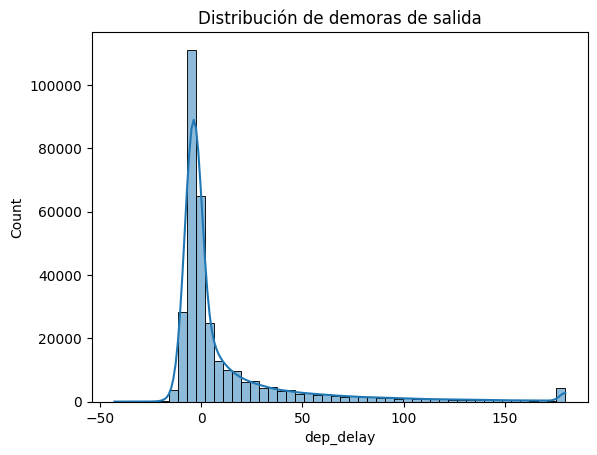

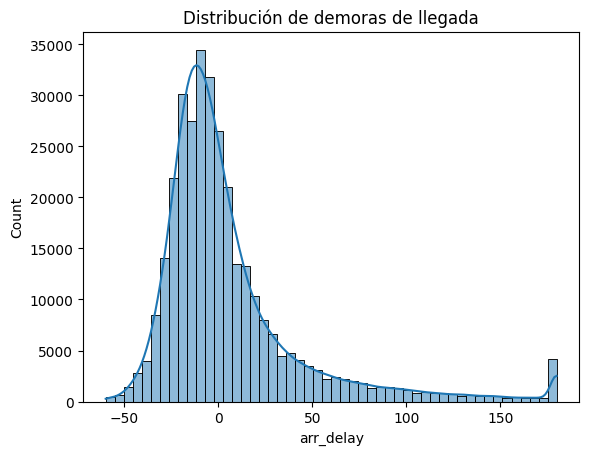

In [26]:
#Exploración descriptiva
# Distribución de demoras
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["dep_delay"].clip(-60,180), bins=50, kde=True)
plt.title("Distribución de demoras de salida")
plt.show()

sns.histplot(df["arr_delay"].clip(-60,180), bins=50, kde=True)
plt.title("Distribución de demoras de llegada")
plt.show()


4. Los protagonistas? Las aerolíneas
“Cada aerolínea tiene su propio patrón de puntualidad. Al comparar con boxplots, vemos que algunas concentran sus vuelos cerca de cero minutos de demora, mientras que otras muestran colas largas hacia retrasos. 

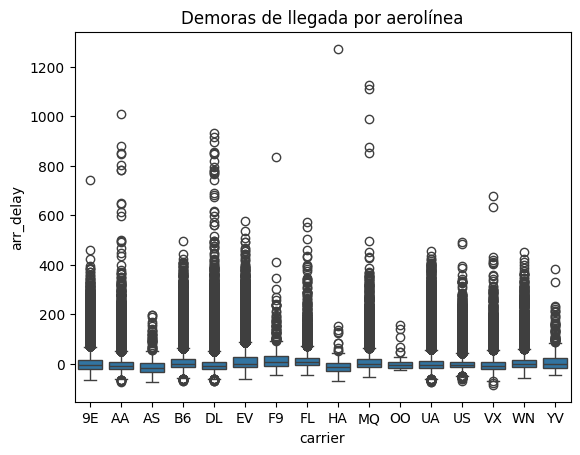

In [27]:
# Boxplot por aerolínea
sns.boxplot(data=df, x="carrier", y="arr_delay")
plt.title("Demoras de llegada por aerolínea")
plt.show()

5. El tiempo como escenario
“Las demoras no ocurren en el vacío: dependen del momento del día y de la fecha. Al graficar por hora, descubrimos que los vuelos de la mañana suelen ser más puntuales, mientras que hacia la tarde y noche las demoras se acumulan. En la serie temporal diaria, aparecen picos que coinciden con días festivos o temporadas altas.”

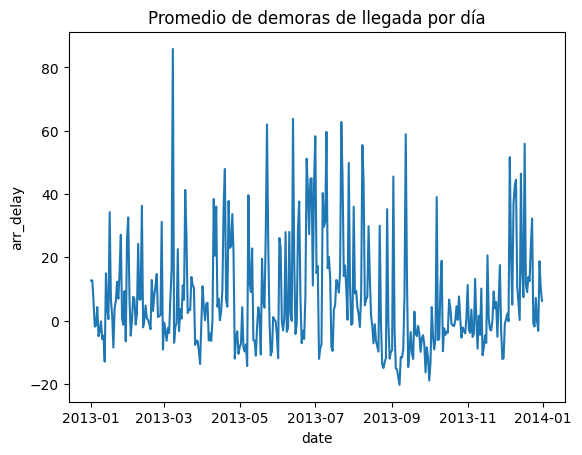

In [28]:
# Serie temporal
df_daily = df.groupby("date")["arr_delay"].mean().reset_index()
sns.lineplot(data=df_daily, x="date", y="arr_delay")
plt.title("Promedio de demoras de llegada por día")
plt.show()

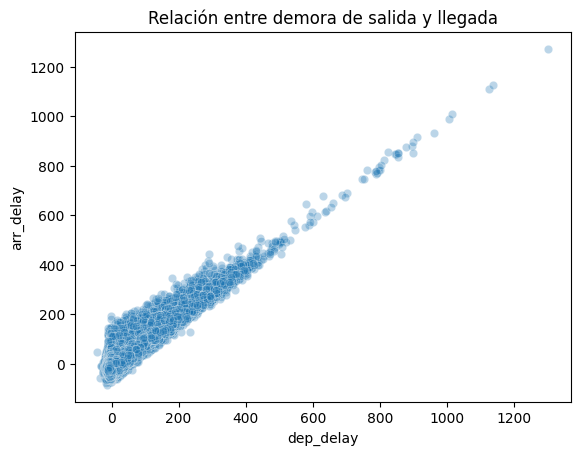

In [29]:
# Salidas V/S Llegadas
sns.scatterplot(x="dep_delay", y="arr_delay", data=df, alpha=0.3)
plt.title("Relación entre demora de salida y llegada")
plt.show()

6. Las rutas y distancias: viajes cortos vs largos
“Cuando relacionamos distancia y tiempo de vuelo, la nube de puntos nos muestra una relación casi lineal: a mayor distancia, mayor tiempo en el aire. Pero también aparecen anomalías: vuelos cortos con tiempos largos, o vuelos largos con tiempos sorprendentemente bajos. Es como descubrir atajos y embotellamientos en el cielo.”

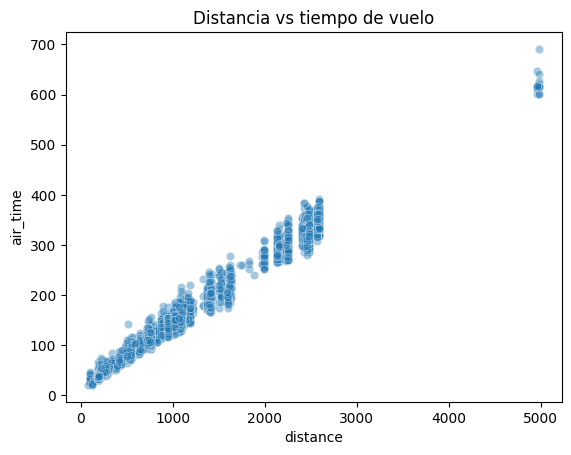

In [31]:
# Distancia V/S Tiempo de vuelo
sns.scatterplot(x="distance", y="air_time", data=df.sample(5000), alpha=0.4)
plt.title("Distancia vs tiempo de vuelo")
plt.show()

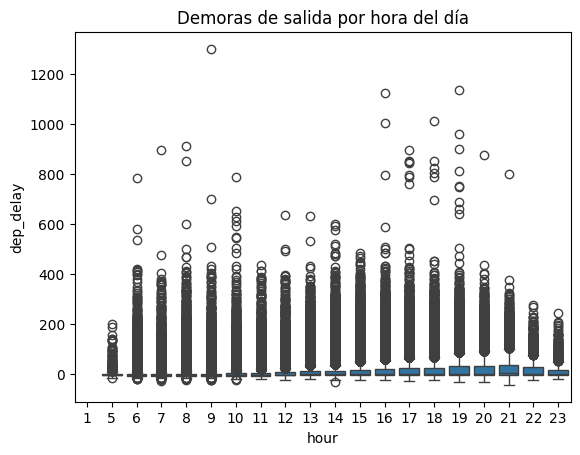

In [32]:
# Demoras por hora del dia
sns.boxplot(x="hour", y="dep_delay", data=df)
plt.title("Demoras de salida por hora del día")
plt.show()

1. Conclusiones: 
   
“En resumen, los datos dicen que:

• 	La mayoría de los vuelos tiene demoras leves, pero existen extremos que afectan la experiencia.

• 	Las aerolíneas difieren en su puntualidad.

• 	La hora del día y los festivos influyen en las demoras.

• 	La relación entre distancia y tiempo de vuelo es clara, pero con excepciones interesantes."
